In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Download leaf desiese from `plantdoc` 
- use `ANN` and classify and find answer.

In [ ]:
import os
import pandas as pd

# Define keywords
healthy_keywords = ["apple leaf", "bell pepper leaf", "blueberry leaf", "cherry leaf", "grape leaf",
                    "peach leaf", "potato leaf", "raspberry leaf", "soyabean leaf", "strawberry leaf", "tomato leaf"]

unhealthy_keywords = ["rust", "scab", "blight", "spot", "rot", "mildew", "virus", "bacterial", "mites"]

# Path to train folder
train_path = os.path.join(os.path.dirname(os.getcwd()), "PlantDoc-Dataset-master", "train")

# Store labeled images
train_data = []

# Loop through each folder in the train dataset
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    
    if not os.path.isdir(folder_path):  
        continue  # Skip non-folder files
    
    # Convert folder name from underscore format to space format
    folder_name = folder.replace("_", " ")  # Example: "tomato leaf bacterial spot" → "tomato leaf bacterial spot"
    
    # Extract the leaf type (first word + "leaf")
    leaf_type = folder_name.split()[0] + " leaf"  # Ensures "tomato leaf", "apple leaf", etc.
    
    # Determine if the leaf is healthy or unhealthy
    if any(keyword in folder_name.lower() for keyword in unhealthy_keywords):
        health_status = "Unhealthy"
    else:
        health_status = "Healthy"
    
    # Process images in folder
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        train_data.append((img_path, leaf_type, health_status))

# Print some labeled data for verification
for i in range(5):  
    print(train_data[i])





In [ ]:
# Create a DataFrame from the train_data
df_train_data = pd.DataFrame(train_data, columns=['Image Path', 'Leaf Type', 'Health Status'])

# Display the first few rows of the DataFrame
print(df_train_data.tail())

In [ ]:
# Count of healthy and unhealthy leaves
health_status_counts = df_train_data['Health Status'].value_counts()
print("Health Status Counts:")
print(health_status_counts)

# Count of different kinds of leaf types
leaf_type_counts = df_train_data['Leaf Type'].value_counts()
print("\nLeaf Type Counts:")
print(leaf_type_counts)

# Count of healthy and unhealthy leaves for each leaf type
leaf_health_counts = df_train_data.groupby(['Leaf Type', 'Health Status']).size().unstack(fill_value=0)
print("\nHealthy and Unhealthy Counts for Each Leaf Type:")
print(leaf_health_counts)

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Path to test folder
test_path = os.path.join(os.path.dirname(os.getcwd()), "PlantDoc-Dataset-master", "test")

# Store labeled images
test_data = []

# Define unhealthy keywords
unhealthy_keywords = ["rust", "scab", "spot", "blight", "mildew", "bacterial", "mosaic", "yellow virus", "mold", "spider mites"]

# Loop through each folder in the test dataset
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    
    if not os.path.isdir(folder_path):  
        continue  # Skip non-folder files
    
    # Convert folder name from underscore format to space format
    folder_name = folder.replace("_", " ")  # Example: "tomato_leaf_bacterial_spot" → "tomato leaf bacterial spot"
    
    # Extract the leaf type (keep it general like "tomato leaf", "apple leaf", etc.)
    leaf_type = folder_name.split()[0] + " leaf"
    
    # Determine if the leaf is healthy or unhealthy
    if any(keyword in folder_name.lower() for keyword in unhealthy_keywords):
        health_status = "Unhealthy"
    else:
        health_status = "Healthy"
    
    # Process images in folder
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        test_data.append((img_path, leaf_type, health_status))

# Display a few images with their labels
num_samples = 5  # Number of images to display
plt.figure(figsize=(10, 5))

for i in range(num_samples):
    img_path, leaf_type, health_status = test_data[i]
    
    # Load image using OpenCV (convert from BGR to RGB)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"{leaf_type}\n{health_status}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Paths
train_path = os.path.join(os.path.dirname(os.getcwd()), "PlantDoc-Dataset-master", "train")

# Image Processing Parameters
IMG_SIZE = (128, 128)  # Resize images to 128x128
NUM_CLASSES = 10  # Set dynamically later

# Data storage
images = []
labels = []

# Extract folder names (leaf types)
leaf_types = []
for folder in os.listdir(train_path):
    folder_name = folder.replace("_", " ")  # Convert underscores to spaces
    leaf_type = folder_name.split()[0] + " leaf"  # Extract general leaf type
    if leaf_type not in leaf_types:
        leaf_types.append(leaf_type)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(leaf_types)

# Load Images and Labels
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if not os.path.isdir(folder_path):  
        continue  # Skip non-folder files
    
    folder_name = folder.replace("_", " ")
    leaf_type = folder_name.split()[0] + " leaf"  # Generalized leaf type
    
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        
        # Load and preprocess image
        img = load_img(img_path, target_size=IMG_SIZE)  # Load image & resize
        img_array = img_to_array(img) / 255.0  # Convert to array & normalize
        
        images.append(img_array)
        labels.append(leaf_type)

# Convert to numpy arrays
images = np.array(images)
labels = label_encoder.transform(labels)  # Convert labels to numbers
NUM_CLASSES = len(label_encoder.classes_)  # Number of unique leaf types

# Split data into train & test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Define the ANN model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMG_SIZE + (3,)),  # Flatten 128x128x3 → 49152
    keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    keras.layers.Dense(64, activation='relu'),  # Hidden layer 2
    keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_test, y_test))

# Save trained model
model.save("leaf_classification_model.h5")


In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [33]:
train_path = os.path.join(os.path.dirname(os.getcwd()), "PlantDoc-Dataset-master", "train")



In [34]:
# Image Processing Parameters
IMG_SIZE = (128, 128)  # Resize images to 128x128
NUM_CLASSES = 10  # Set dynamically later



In [35]:
# Data storage
images = []
labels = []


In [36]:
# Extract folder names (leaf types)
leaf_types = []
for folder in os.listdir(train_path):
    folder_name = folder.replace("_", " ")  # Convert underscores to spaces
    leaf_type = folder_name.split()[0] + " leaf"  # Extract general leaf type
    if leaf_type not in leaf_types:
        leaf_types.append(leaf_type)

In [37]:

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(leaf_types)

LabelEncoder()

In [38]:


# Load Images and Labels
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    if not os.path.isdir(folder_path):  
        continue  # Skip non-folder files
    
    folder_name = folder.replace("_", " ")
    leaf_type = folder_name.split()[0] + " leaf"  # Generalized leaf type
    
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        
        # Load and preprocess image
        img = load_img(img_path, target_size=IMG_SIZE)  # Load image & resize
        img_array = img_to_array(img) / 255.0  # Convert to array & normalize
        
        images.append(img_array)
        labels.append(leaf_type)


In [39]:

# Convert to numpy arrays
images = np.array(images)
labels = label_encoder.transform(labels)  # Convert labels to numbers
NUM_CLASSES = len(label_encoder.classes_)  # Number of unique leaf types

# Split data into train & test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)


In [40]:

# Define the ANN model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMG_SIZE + (3,)),  # Flatten 128x128x3 → 49152
    keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    keras.layers.Dense(64, activation='relu'),  # Hidden layer 2
    keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])


c:\Users\anurag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [42]:

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,300,685 (24.04 MB)

 Trainable params: 6,300,685 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_test, y_test))

# Save trained model
model.save("leaf_classification_model.h5")


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1564 - loss: 11.6842 - val_accuracy: 0.2543 - val_loss: 2.9497
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2780 - loss: 2.4742 - val_accuracy: 0.1688 - val_loss: 2.6966
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2699 - loss: 2.4429 - val_accuracy: 0.2051 - val_loss: 2.5141
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3064 - loss: 2.2659 - val_accuracy: 0.1560 - val_loss: 2.6087
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2804 - loss: 2.3749 - val_accuracy: 0.1603 - val_loss: 2.7060
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3458 - loss: 2.0929 - val_accuracy: 0.2671 - val_loss: 2.3031
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3946 - loss: 1.9016 - val_accuracy: 0.3056 - val_loss: 2.3155
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3781 - loss: 1.9633 - val_accuracy: 0.2863 - 

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(13, activation='softmax')  # 13 classes for different leaf types
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(x_test, y_test))


c:\Users\anurag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,741 (12.64 MB)

 Trainable params: 3,313,741 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2696 - loss: 2.3675 - val_accuracy: 0.2799 - val_loss: 2.2772
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3114 - loss: 2.1933 - val_accuracy: 0.2863 - val_loss: 2.2135
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.2945 - loss: 2.1232 - val_accuracy: 0.3034 - val_loss: 2.2159
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3223 - loss: 1.9972 - val_accuracy: 0.3291 - val_loss: 2.0174
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3851 - loss: 1.8425 - val_accuracy: 0.2991 - val_loss: 2.1345
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.4008 - loss: 1.7864 - val_accuracy: 0.3162 - val_loss: 2.0955
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5127 - loss: 1.5206 - val_accuracy: 0.2778 - val_loss: 2.1316
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.5744 - loss: 1.3767 - val_accuracy: 0.3333 - 

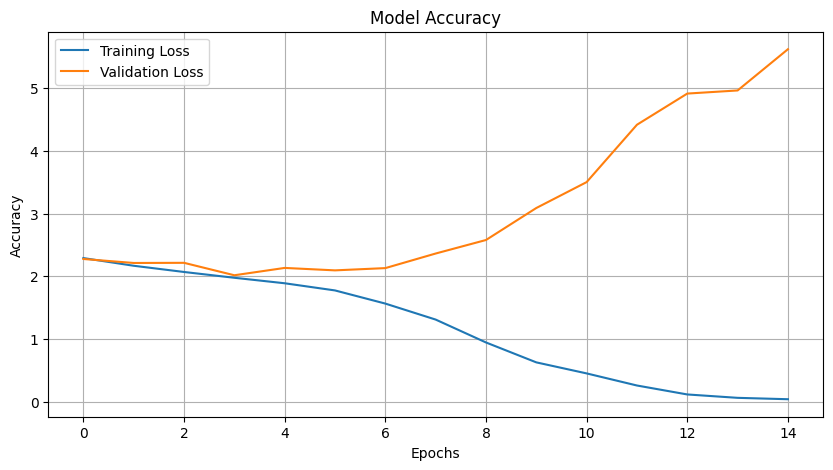

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()


### Train an ANN for `binary classifier` for `cat vs dog` images, use `imagenet` dataset